In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sn
import scipy as sc
import pandas as pd
import pickle
import unyt as u
import h5py
from sklearn.linear_model import LinearRegression

<AxesSubplot:>

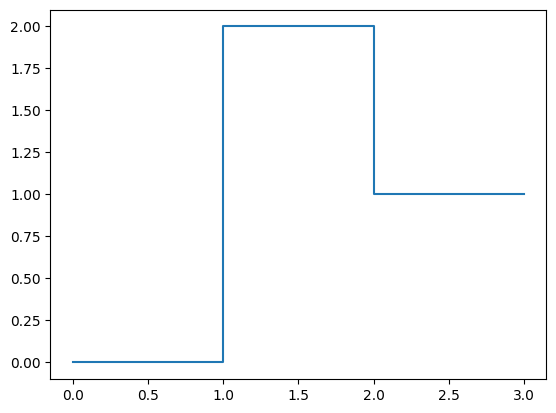

In [46]:
height, bins = np.histogram([1, 2, 1], bins=[0, 1, 2, 3])
height = np.hstack((height[0],height))
# height = np.append(height,height[-1])

sn.lineplot(x=bins, y=height, drawstyle='steps-pre')
# sn.histplot([1, 2, 1], bins=[0, 1, 2, 3])

In [3]:
f = h5py.File("/mnt/scratch/tairaeli/rvir_masses.hdf5")
f.keys()

<KeysViewHDF5 ['all_data', 'all_data.__table_column_meta__']>

In [22]:
n = 0
for i in f["all_data.__table_column_meta__"]:
    n+=1
    print(i)
print(n)

b'datatype:'
b'- {name: redshift, datatype: float64}'
b'- {name: snapshot, datatype: string}'
b'- {name: radius, unit: kpc, datatype: float64}'
b'- {name: total_mass, unit: solMass, datatype: float64}'
b'- {name: dm_mass, unit: solMass, datatype: float64}'
b'- {name: stars_mass, unit: solMass, datatype: float64}'
b'- {name: young_stars_mass, unit: solMass, datatype: float64}'
b'- {name: old_stars_mass, unit: solMass, datatype: float64}'
b'- {name: gas_mass, unit: solMass, datatype: float64}'
b'- {name: gas_metal_mass, unit: solMass, datatype: float64}'
b'- {name: gas_H_mass, unit: solMass, datatype: float64}'
b'- {name: gas_HI_mass, unit: solMass, datatype: float64}'
b'- {name: gas_HII_mass, unit: solMass, datatype: float64}'
b'- {name: gas_CII_mass, unit: solMass, datatype: float64}'
b'- {name: gas_CIII_mass, unit: solMass, datatype: float64}'
b'- {name: gas_CIV_mass, unit: solMass, datatype: float64}'
b'- {name: gas_OVI_mass, unit: solMass, datatype: float64}'
b'- {name: gas_OVII_mas

In [37]:
"RD0018"
f["all_data"][0]

(5.99654865, b'DD0138', 2.61360744, 2.03450316e+08, 1.78641168e+08, 0., 0., 1.78641168e+08, 24809148.40248626, 0.00248091, 10588282.95980213, 10588282.95980213, 8266669.82420194, 1.60898521e-05, 1.93698491e-05, 6.511477e-08, 8.28609967e-16, 0., 2.0211728e-06, 2.99545393e-06, 1.95063124e-06, 7.58214992e-08, 0.)

In [36]:
r2_5 = []
for row in f["all_data"]:
    if row[1].decode('UTF-8') == "RD0018":
        r2_5.append(row)
print(r2_5)

[(2.49999962, b'RD0018', 42.50475212, 1.14266444e+11, 9.585513e+10, 5.85420858e+09, 1.03275891e+08, 1.01606063e+11, 1.25571053e+10, 55541353.71455062, 4.800103e+09, 4.800103e+09, 4.70108591e+09, 554181.98868764, 58592.70719706, 5063.36827623, 2220.0273046, 15112.24682397, 85077.16608665, 101255.29045692, 4083.46358707, 1209.52940747, 405.41097154)]


In [39]:
42.5*0.5

21.25

In [2]:
with open("/mnt/scratch/tairaeli/pair_comp_10_04/halo2392/redshift2.5/FG_2009/data/salsa_out_dict.pickle","rb") as f:
    df = pickle.load(f)

In [3]:
# df["H I"]["FG_2009"]

# df = h5py.File("/mnt/scratch/tairaeli/pair_comp_10_04/halo2392/redshift2.5/rays_HI/ray3.h5")

In [4]:
# df["grid"]["H_p0_number_density"][0:20]

In [5]:
uvb_file = "/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/fg20_spec_lambda.dat"
rs_range = [1.2,2.7]

# loading in array for desired energy bins
uvb_rs = np.genfromtxt(uvb_file, max_rows = 1)

# creating a mask to isolate desired redshift data
rs_mask = np.where((uvb_rs>=rs_range[0]) & (uvb_rs<=rs_range[1]))

# reading in actual data
uvb_data = np.genfromtxt("/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/fg20_spec_lambda.dat", skip_header=11)

# masking out uvb data with redshift mask
uvb_data = uvb_data[:,rs_mask]

# assigning wave range to variable
uvb_wave = uvb_data[:,0]

# labeling wave data (Angstroms)
nuvb_wave = uvb_wave * u.Angstrom

# converting wavelengths to energy
Ryd = 2.1798723611035e-18 * u.J
nu = nuvb_wave.to("J", equivalence="spectral") / Ryd
nu = nu.to_value()
nu = np.round(nu,6)

# locating pairs of data within wave data that are duplicates
unq_nu, freq = np.unique(nu, return_counts=True)
pairs = [(nu == val).nonzero()[0] for val in unq_nu[freq>1]] # list of arrays w/ indicies

# goes through each of the pairs of duplicated data and adjusts the wavelengths very slightly
for pair in pairs:
    print(pair[0],pair[1],flush=True)
    assert pair.size==2, "More than two duplicates found"
    assert pair[0] < pair[1]

    # adjust wavelenghts by 0.0001%
    nu[pair[0]] -= 0.000001 * nu[pair[0]]
    nu[pair[1]] += 0.000001 * nu[pair[1]]

irs = 0

spec = uvb_data[:,0,irs]*u.erg/u.cm**2

spec = np.log10(spec)

# ensuring the nu array is ordered correctly
if len(np.where(np.diff(nu[:,irs])>=0)) > 0:
    nu_msk = np.argsort(nu[:,irs])[::-1]
    nu[:,irs] = nu[nu_msk,irs]
    spec = spec[nu_msk]

np.where(np.diff(nu[:,irs])>=0)

(array([], dtype=int64),)

In [2]:
def read_cloudy_in(file):
    df = pd.read_csv(file,
                     header = None,
                    skiprows = 5,
                    skipfooter = 3,
                    delim_whitespace = True)
    
    df = df.drop(columns = 0)
    
    for i in range(len(df[1])):
        df[1][i] = float(df[1][i].replace(")","").replace("(",""))
        df[2][i] = float(df[2][i].replace(")","").replace("(",""))
    
    return df

In [4]:
hm2012 = read_cloudy_in("/mnt/scratch/tairaeli/hm_2012_uvb_dat/z_2.5481e+00.out")
# hm2012 = hm2012.drop(columns=["Unnamed: 0"])
hm2012.head()

/mnt/home/tairaeli/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,1,2
0,0.009094,-19.32023
1,0.009546,-19.328366
2,0.010015,-19.334587
3,0.010507,-19.338549
4,0.011023,-19.340054


In [5]:
fg2009 = pd.read_csv("/mnt/scratch/tairaeli/fg_2009_uvb_dat/fg_uvb_dec11_z_2.5.dat",
                     skiprows=2,delimiter="   ",
                     header=None)
fg2009.head()

/mnt/home/tairaeli/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1
0,0.500000,16.608715
1,0.517632,16.000343
2,0.535887,15.421625
3,0.554785,14.807810
4,0.574349,14.160724


In [4]:
# hm2012_eV = hm2012[0].to_numpy()*u.angstrom
# hm2012_eV = hm2012_eV.to("eV", equivalence="spectral")
# hm2012_int = hm2012[1].to_numpy()*u.ergs/u.s/u.Mpc**3/u.Hz
# hm2012_conv = (hm2012_eV.to("J")/u.h).to("1/s")
# hm2012_int = (hm2012_int.to("erg/cm**3")*hm2012_conv).to_value()*10**28
fg2009 = pd.read_csv("/mnt/scratch/tairaeli/fg_2009_uvb_dat/fg_uvb_dec11_z_2.5.dat",
                     skiprows=2,delimiter="   ",
                     header=None)

fg2009_ev = fg2009[0]*13.605703976
fg2009_int = ((fg2009_ev.to_list()*u.eV).to("J")/(u.h)).to_value() # 1/s
fg2009_int = (fg2009[1]*10**(-21))*4*np.pi*fg2009_int
fg2009.head()

/mnt/home/tairaeli/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1
0,0.500000,16.608715
1,0.517632,16.000343
2,0.535887,15.421625
3,0.554785,14.807810
4,0.574349,14.160724


/mnt/home/tairaeli/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
# fg2020_lam = read_cloudy_in("/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/fg20_spec_lambda.dat")
# fg2020_w_nu = read_cloudy_in("/mnt/scratch/tairaeli/fg_2020_uvb_dat_w_nu/z_1.8200e+00.out")

fg2020 = read_cloudy_in("/mnt/scratch/tairaeli/fg_2020_uvb_dat/z_2.5000e+00.out")
fg2020[1] = fg2020[1]*13.605703976
fg2020[3] = ((fg2020[1].to_list()*u.eV).to("J")/(u.h)).to_value()
fg2020[4] = (10**fg2020[2])*4*np.pi*fg2020[3]

hm2012 = read_cloudy_in("/mnt/scratch/tairaeli/hm_2012_uvb_dat/z_2.5481e+00.out")
hm2012[1] = hm2012[1]*13.605703976
hm2012[3] = ((hm2012[1].to_list()*u.eV).to("J")/(u.h)).to_value()
hm2012[4] = (10**hm2012[2])*4*np.pi*hm2012[3]

pcw2019 = read_cloudy_in("/mnt/scratch/tairaeli/pcw_uvb_dat/z_2.4790e+00.out")
pcw2019[1] = pcw2019[1]*13.605703976
pcw2019[3] = ((pcw2019[1].to_list()*u.eV).to("J")/(u.h)).to_value()
pcw2019[4] = (10**pcw2019[2])*4*np.pi*pcw2019[3]

/mnt/home/tairaeli/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [8]:
fg2020_lam = pd.read_csv("/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/fg20_spec_nu.dat",
                         skiprows = 10,
                         delimiter="   ")["1.82"]
# print(fg2020_lam.head())
fg2020_lam = np.log10(fg2020_lam)
fg2020_lam.head()

/mnt/home/tairaeli/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


0.10    2.177507
0.15    2.053494
0.20    1.915498
0.25    1.782786
0.30    1.776894
Name: 1.82, dtype: float64

In [5]:
ion_energies = pd.read_csv("./ionization_energies.txt", delimiter = "  ")
imask = ["N_II","N_IV","Ne_VII", "C_II",
         "S_II", "S_III", "S_IV","Mg_II", "Al_III", "O_III", 'Ne_VIII', 'Mg_X']
for ion in imask:
    ion_energies = ion_energies[ion_energies["ion"] != ion]
ion_energies = ion_energies.reset_index()
print(ion_energies["ion"].values)

['C_III' 'C_IV' 'H_I' 'O_VI' 'Si_II' 'Si_III' 'Si_IV' 'N_V']


/mnt/home/tairaeli/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [14]:
ion_name_dict = {"H_I":r"H $\mathrm{\i}$",
                 "Si_II":r"Si $\mathrm{\i\i}$",
                 "Si_III":r"Si $\mathrm{\i\i\i}$",
                 "C_III":r"C $\mathrm{\i\i\i}$",
                 "Si_IV":r"Si $\mathrm{\i v}$",
                 "C_IV":r"C $\mathrm{\i v}$",
                 "N_V":r"N $\mathrm{v}$",
                 "O_VI":r"O $\mathrm{v\i}$"}

In [6]:
import matplotlib.transforms as transforms

/mnt/home/tairaeli/anaconda3/envs/astro_env/lib/python3.7/site-packages/ipykernel_launcher.py:83: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/mnt/home/tairaeli/anaconda3/envs/astro_env/lib/python3.7/site-packages/ipykernel_launcher.py:84: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/mnt/home/tairaeli/anaconda3/envs/astro_env/lib/python3.

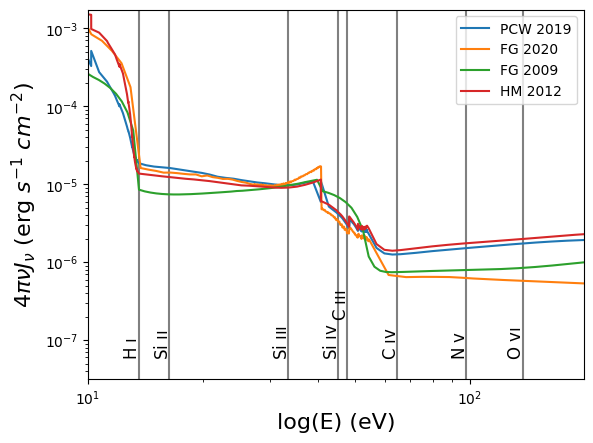

In [63]:
cmap = colormaps["Dark2"]
colors = cmap(np.linspace(0, 0.7, len(ion_energies["ion"])))

# for i,ion in enumerate(ion_energies["ion"]):
#     plt.axvline(np.log10(ion_energies["ionization energy (eV)"][i]),
#              linestyle = "-", color = "grey")

#     if ion == "C_III":
#         plt.text(np.log10(ion_energies["ionization energy (eV)"][i])+0.001,-7.2,
#                 ion, fontsize=12, color = "black", rotation="vertical")
#     else:
#         plt.text(np.log10(ion_energies["ionization energy (eV)"][i])-0.05,-7.2,
#                 ion, fontsize=12, color = "black", rotation = "vertical")

# plt.plot(np.log10(pcw2019[1].astype(np.float)),
#          np.log10(pcw2019[4].astype(np.float)), label = "PCW 2019")
# plt.plot(np.log10(fg2020[1].astype(np.float)),
#          np.log10(fg2020[4].astype(np.float)), label = "FG 2020")
# plt.plot(np.log10(fg2009_ev),
#          np.log10(fg2009_int), label = "FG 2009")
# plt.plot(np.log10(hm2012[1].astype(np.float)),
#          np.log10(hm2012[4].astype(np.float)), label = "HM 2012")

fig, ax = plt.subplots()
trans = ax.get_yaxis_transform()

min_x = 10
max_x = 10**2.3

for i,ion in enumerate(ion_energies["ion"]):
    ax.axvline(ion_energies["ionization energy (eV)"][i],
             linestyle = "-", color = "grey")
    # print(ion)
    # transformed_vals = (ion_energies["ionization energy (eV)"][i] - min_x)/(max_x-min_x)
    # # print(transformed_vals)
    # if ion == "C_III":
    #     ax.text(ion_energies["ionization energy (eV)"][i], 10**(-7.2),
    #             ion, fontsize=12, color = "black", rotation="vertical")
    # else:
    #     ax.text(ion_energies["ionization energy (eV)"][i]-10**(0.3), 10**(-7.2),
    #             ion, fontsize=12, color = "black", rotation = "vertical")

# C III
ax.text(ion_energies["ionization energy (eV)"][0]-10**0.63, 10**(-6.7),
                ion_name_dict[ion_energies["ion"][0]], 
                fontsize=12, color = "black", rotation="vertical")

# C IV
ax.text(ion_energies["ionization energy (eV)"][1]-10**0.75, 10**(-7.2),
                ion_name_dict[ion_energies["ion"][1]], 
                fontsize=12, color = "black", rotation="vertical")

# H I
ax.text(ion_energies["ionization energy (eV)"][2]-10**0.09, 10**(-7.2),
                ion_name_dict[ion_energies["ion"][2]], 
                fontsize=12, color = "black", rotation="vertical")

# O VI
ax.text(ion_energies["ionization energy (eV)"][3]-10**1.1, 10**(-7.2),
                ion_name_dict[ion_energies["ion"][3]], 
                fontsize=12, color = "black", rotation="vertical")

# Si II
ax.text(ion_energies["ionization energy (eV)"][4]-10**0.17, 10**(-7.2),
                ion_name_dict[ion_energies["ion"][4]], 
                fontsize=12, color = "black", rotation="vertical")

# Si III
ax.text(ion_energies["ionization energy (eV)"][5]-10**0.47, 10**(-7.2),
                ion_name_dict[ion_energies["ion"][5]], 
                fontsize=12, color = "black", rotation="vertical")

# Si IV
ax.text(ion_energies["ionization energy (eV)"][6]-10**0.57, 10**(-7.2),
                ion_name_dict[ion_energies["ion"][6]], 
                fontsize=12, color = "black", rotation="vertical")

# N V
ax.text(ion_energies["ionization energy (eV)"][7]-10**0.93, 10**(-7.2),
                ion_name_dict[ion_energies["ion"][7]], 
                fontsize=12, color = "black", rotation="vertical")

ax.plot(pcw2019[1].astype(np.float),
         pcw2019[4].astype(np.float), label = "PCW 2019")
ax.plot(fg2020[1].astype(np.float),
         fg2020[4].astype(np.float), label = "FG 2020")
ax.plot(fg2009_ev,
         fg2009_int, label = "FG 2009")
ax.plot(hm2012[1].astype(np.float),
         hm2012[4].astype(np.float), label = "HM 2012")

ax.set_xlim(min_x,max_x)
ax.set_ylim(bottom=10**(-7.5))
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"4$\pi$$\nu$$J_{\nu}$ (erg $s^{-1}$ $cm^{-2}$)", fontsize = 16)
ax.set_xlabel("log(E) (eV)", fontsize = 16)
plt.savefig("./uvb_intens_plot_draft.pdf")


In [30]:
file_names = [""]

def cloudy_plot(file_list, names, colors, rs):
    plt.figure(dpi = 500)
    for i, file in enumerate(file_list):
        df = read_cloudy_in(file)
        plt.plot(df[1],df[2], label = names[i], color = colors[i])

    # plt.yscale('log')
    plt.xlim(0,10)
    plt.ylim([-24,-19])
    plt.title(f"Intensity from Cloudy Input at z = {rs}")
    plt.ylabel("log($\Delta$ I) (erg/$cm^2$)")
    plt.xlabel("E (Ryd)")
    plt.legend()
    plt.grid()
    plt.savefig("./uvb_intensity_plot.png", dpi = 500)
    plt.show()

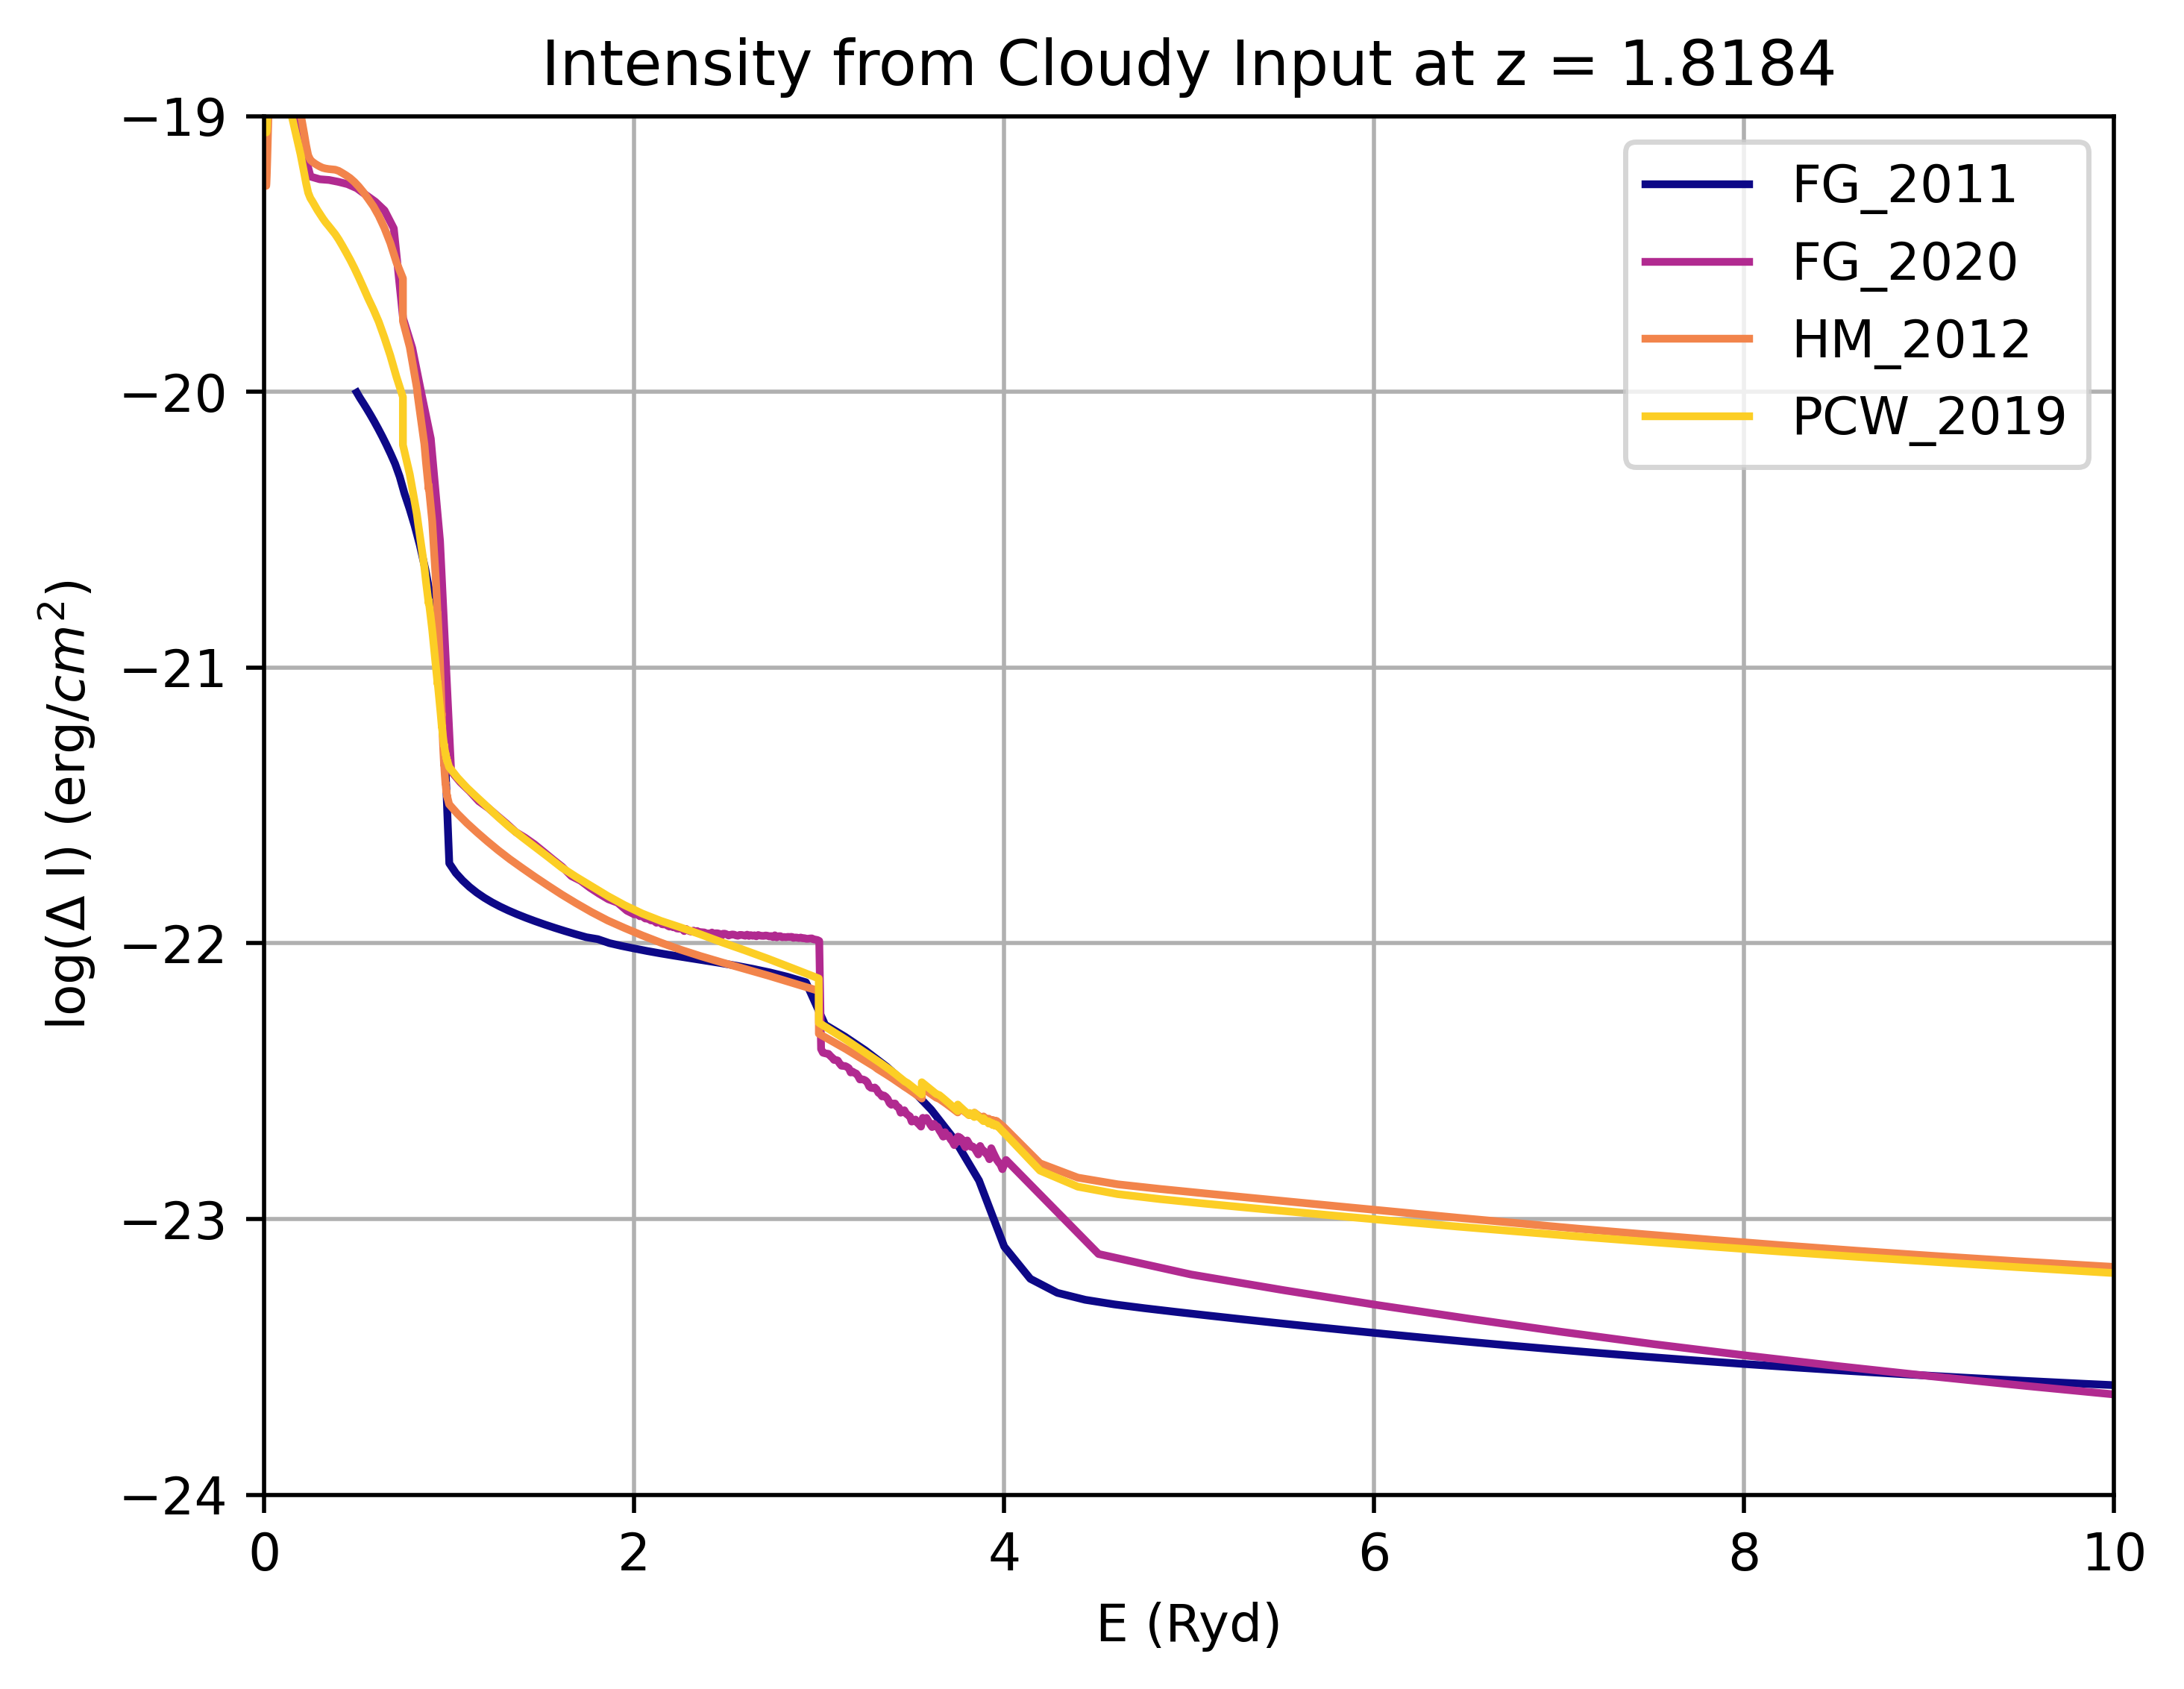

In [15]:
stonk = "/mnt/home/tairaeli/astro_libs/cloudy_cooling_tools/examples/grackle/FG11_UVB"


uvb_list = ["/mnt/home/tairaeli/astro_libs/cloudy_cooling_tools/examples/grackle/FG11_UVB/z_1.8184e+00.out",
            "/mnt/scratch/tairaeli/fg_2020_uvb_dat/z_1.8200e+00.out",
            "/mnt/home/tairaeli/astro_libs/cloudy_cooling_tools/examples/grackle/HM12_UVB/z_1.8184e+00.out",
            # "/mnt/home/tairaeli/astro_libs/cloudy_cooling_tools/examples/grackle/P19_UVB/z_1.8710e+00.out"
            "/mnt/scratch/tairaeli/pcw_uvb_dat/z_1.8710e+00.out",
            # "/mnt/scratch/tairaeli/fg_2020_uvb_dat_w_nu/z_1.8200e+00.out"
]

file_names = ["FG_2011",
              "FG_2020",
              "HM_2012",
              "PCW_2019",
            #   "FG_2020_bad"
              ]
colors = plt.cm.plasma([0.0,0.4,0.7,0.9,1.0])

cloudy_plot(uvb_list, file_names, colors, 1.8184)

In [54]:
fg_20 = "/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/fg20_spec_nu.dat"
pcw_19 = "/mnt/home/tairaeli/Junk/cloudy_cooling_tools_degraded/examples/ion_balance/test_bin/puchwein19_bkgthick.out"

def read_raw_uvb(file, rs_bounds):
    """
    Loads in raw UVB data for a given background

    args:

        file (str) - path to uvb file

        rs_bounds (list) - bounds of rs, should be length = 2

    returns:

        nuvb_wave (yt_array) - array of uvb wavelengths in angrstoms

        spec (yt_array) - array of uvb intensity at a given wavelength.
                          in units of erg/cm**2
    """
    # loading in array for desired energy bins
    uvb_rs = np.genfromtxt(file, max_rows = 1)
    
    # creating a mask to isolate desired redshift data
    rs_mask = np.where((uvb_rs>=rs_bounds[0]) & (uvb_rs<=rs_bounds[1]))

    # masking redhsifts with desired analysis range using previously generated mask
    uvb_rs = uvb_rs[rs_mask]

    print("z = ",uvb_rs)

    # reading in actual data
    uvb_data = np.genfromtxt(file, skip_header=11)

    # assigning wave range to variable
    uvb_wave = uvb_data[:,0]

    # masking out uvb data with redshift mask
    uvb_data = uvb_data[:,rs_mask]

    # labeling wave data (Angstroms)
    nuvb_wave = uvb_wave * u.Angstrom

    # calling the uvb intensity data for the current redshift
    spec = uvb_data[:,0,0]*u.erg/u.cm**2

    return nuvb_wave, spec

In [56]:
wave_fg_20, spec_fg_20 = read_raw_uvb(fg_20,[1.85,1.875])
wave_pcw_19, spec_pcw_19 = read_raw_uvb(pcw_19,[1.85,1.875])

z =  [1.86]
z =  [1.871]


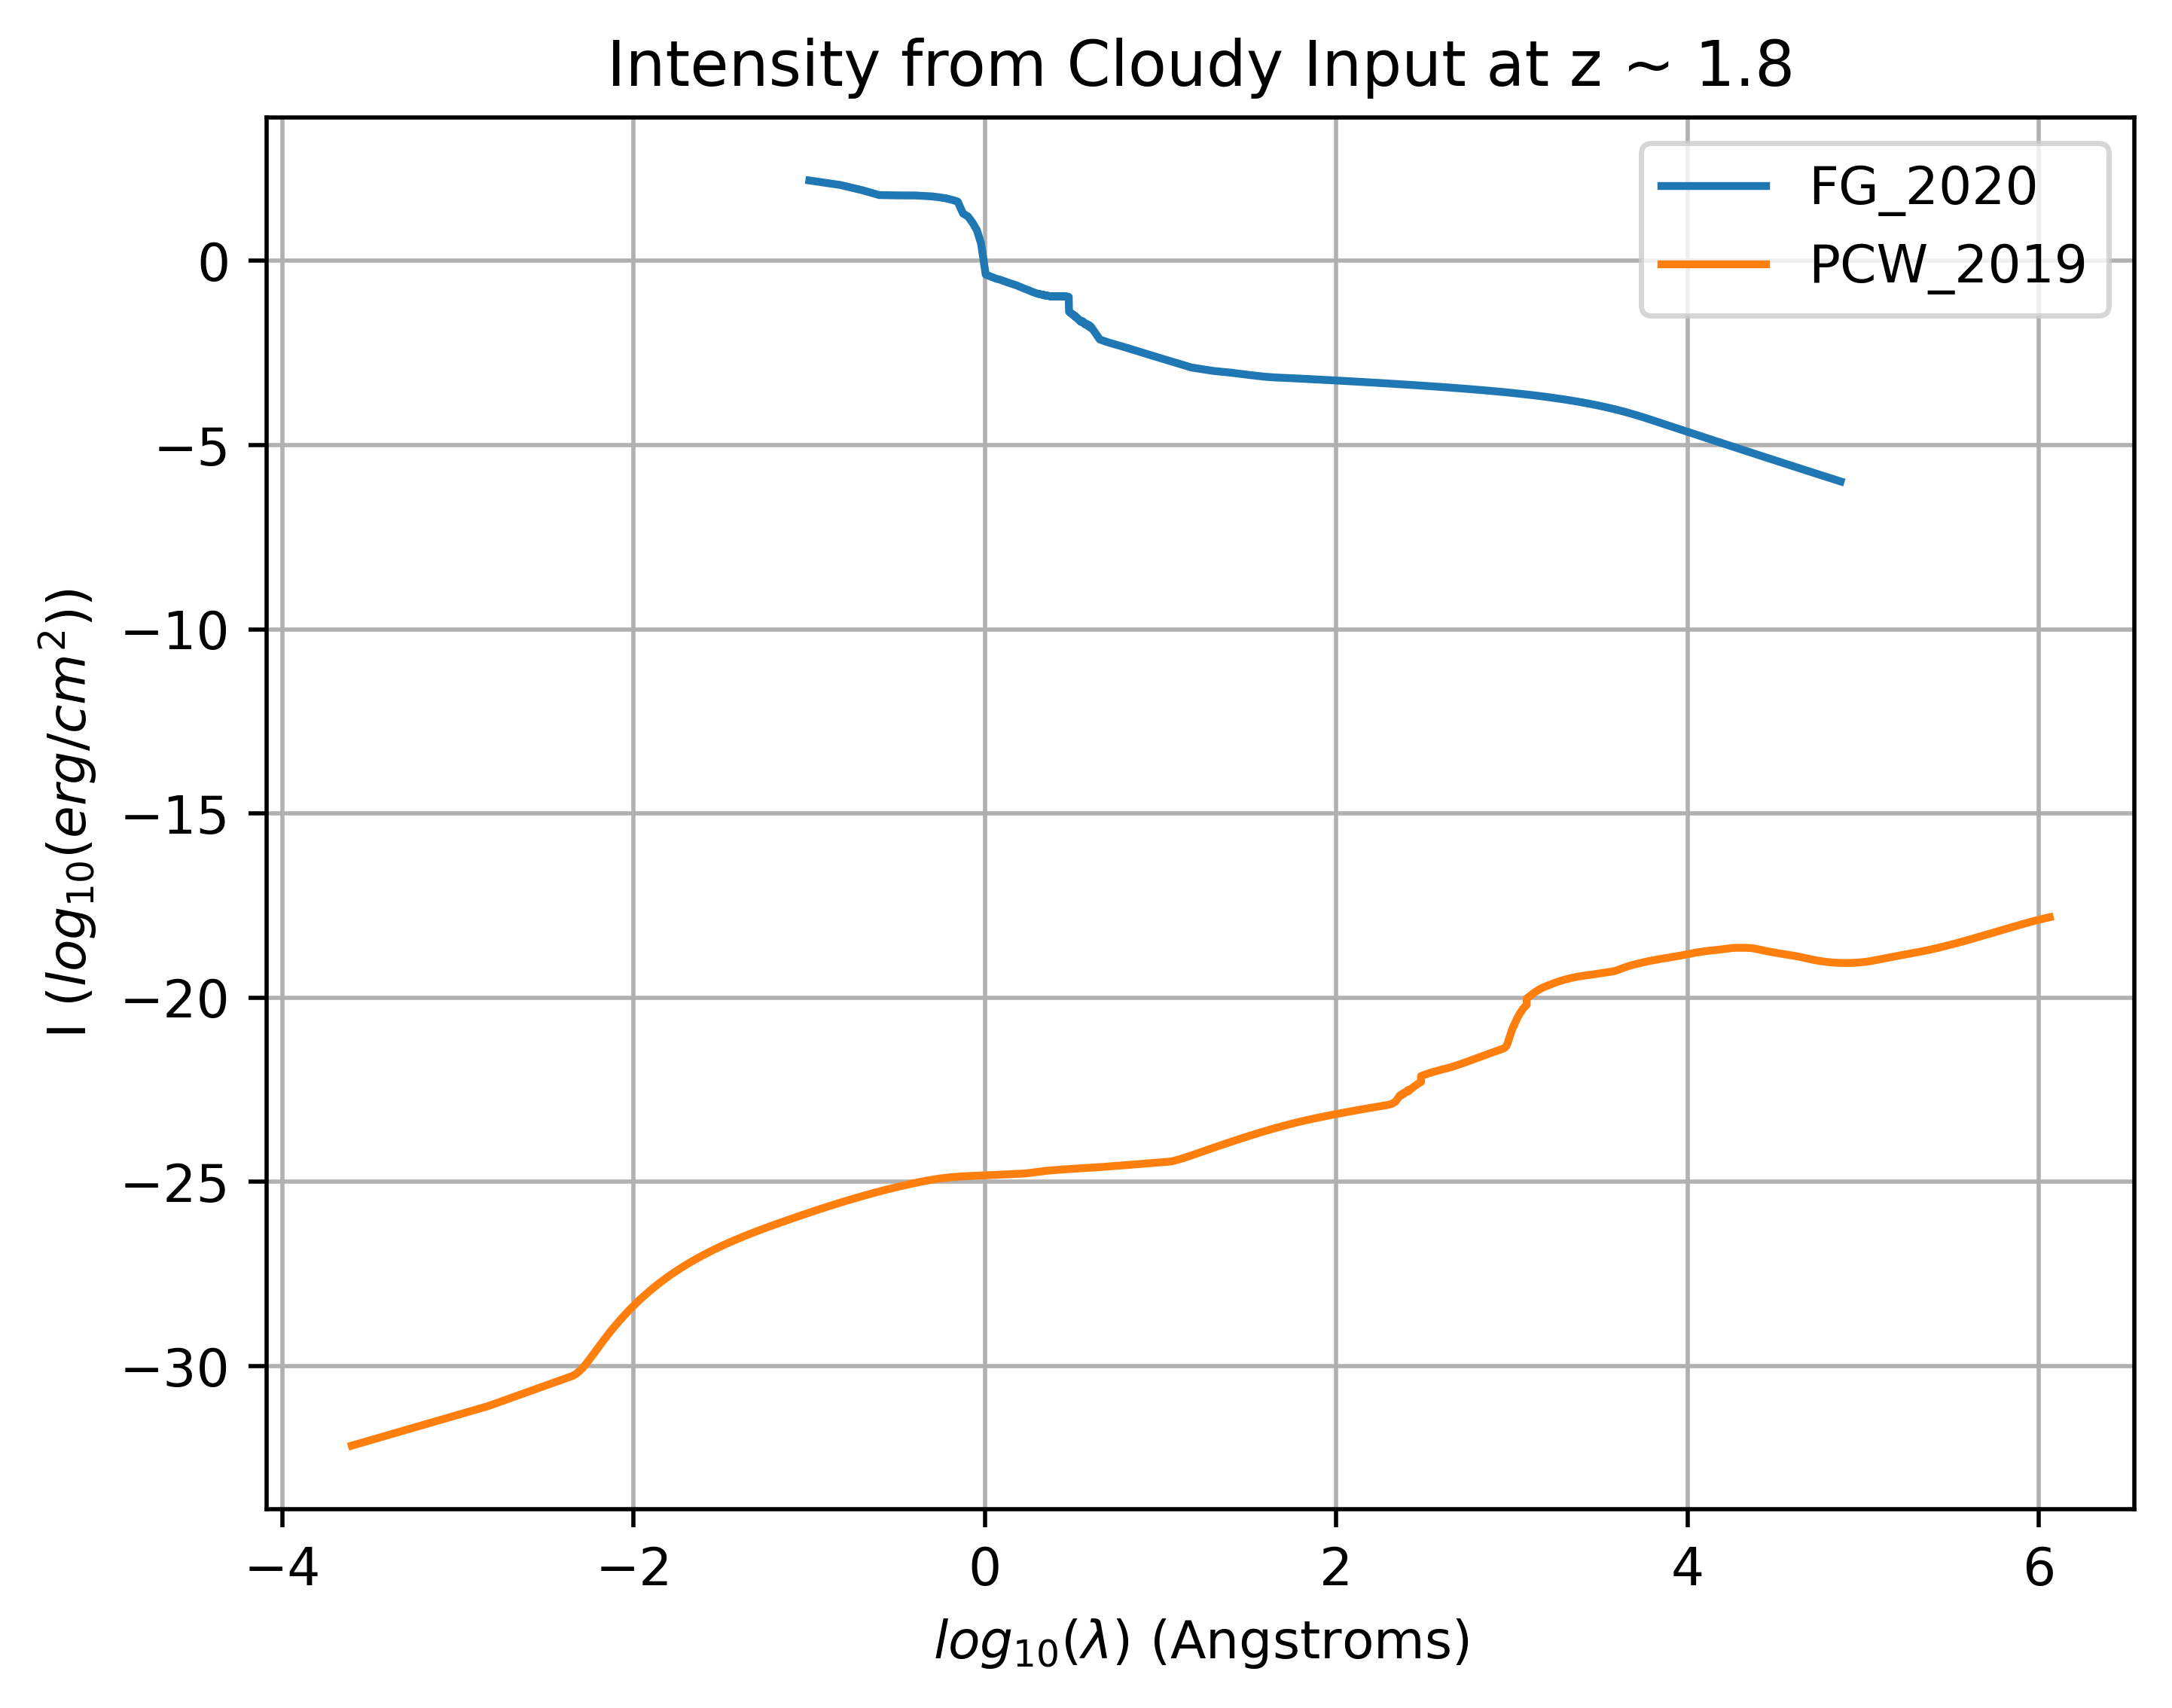

In [57]:
plt.figure(dpi = 500)
plt.plot(np.log10(wave_fg_20), np.log10(spec_fg_20), label = "FG_2020")
plt.plot(np.log10(wave_pcw_19), np.log10(spec_pcw_19), label = "PCW_2019")
# plt.yscale('log')
# plt.xlim(0,10)
# plt.ylim([-24,-19])
plt.title(f"Intensity from Cloudy Input at z ~ {1.8}")
plt.ylabel("I ($log_{10}$($erg$/$cm^2$))")
plt.xlabel("$log_{10}$($\lambda$) (Angstroms)")
plt.legend()
plt.grid()
# plt.savefig("./uvb_intensity_plot.png", dpi = 500)
plt.show()

In [28]:
uvb_data

array([[1.00000000e-01, 9.75158590e+00, 1.05146141e+01, ...,
        6.54499529e-06, 6.32070275e-06, 0.00000000e+00],
       [1.50000000e-01, 7.29358516e+00, 7.94807585e+00, ...,
        5.11085630e-06, 4.93571073e-06, 0.00000000e+00],
       [2.00000000e-01, 5.91497609e+00, 6.40935283e+00, ...,
        4.28825932e-06, 4.14130360e-06, 0.00000000e+00],
       ...,
       [7.35000000e+04, 4.98826148e-08, 5.44044641e-08, ...,
        3.24377799e-12, 3.13261593e-12, 0.00000000e+00],
       [7.40000000e+04, 4.93819147e-08, 5.38580558e-08, ...,
        3.21049885e-12, 3.10047724e-12, 0.00000000e+00],
       [7.45000000e+04, 4.88896683e-08, 5.33208755e-08, ...,
        3.17778706e-12, 3.06888647e-12, 0.00000000e+00]])

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying 

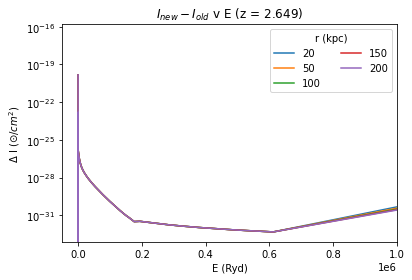

In [8]:
# with open("/mnt/home/tairaeli/trident_uncertainty/mods/backgrounds/stellar_pops/d_20_kpc_rs.pkl","rb") as f:
#     rs_lis = pickle.load(f)

d_lis = [20,50,100,150,200]

for d in d_lis:
    my_dat = read_cloudy_in(f"/mnt/gs21/scratch/tairaeli/{d}_kpc_dat/z_2.6490e+00.out")
    
    put_dat = read_cloudy_in(f"/mnt/home/tairaeli/astro_libs/cloudy_cooling_tools/examples/grackle/P19_UVB/z_2.6490e+00.out")
    
    put_dat[2] = put_dat[2].replace(-np.inf,-50)

    int_diff = 10**(my_dat[2]) - 10**(put_dat[2])

    plt.plot(my_dat[1],int_diff, label = str(d))
        
plt.yscale('log')
plt.xlim([-0.05e6,1e6])
plt.title("$I_{new} - I_{old}$ v E (z = 2.649)")
plt.ylabel("$\Delta$ I ($\odot$/$cm^2$)")
plt.xlabel("E (Ryd)")
plt.legend(title = "r (kpc)", ncol = 2)

In [21]:
20*1155/60/24

16.041666666666668

In [8]:
uvb_lis = ["/mnt/home/tairaeli/Junk/cloudy_cooling_tools_degraded/examples/ion_balance/test_bin/puchwein19_bkgthick.out",
           "/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/hm2012_ss_hr.h5",
           "/mnt/home/tairaeli/trident_uncertainty/mods/abundances/data_bin/fg2009_ss_hr.h5"]

with open("./uvb.pickle","wb") as f:
    pickle.dump(uvb_lis,f)

In [12]:
with open("./uvb.pickle","rb") as f:
    uvb_lis = pickle.load(f)

for uvb in uvb_lis:
    df = np.genfromtxt(uvb,skip_header = 10)

ValueError: Some errors were detected !
    Line #12 (got 61 columns instead of 60)
    Line #13 (got 61 columns instead of 60)
    Line #14 (got 61 columns instead of 60)
    Line #15 (got 61 columns instead of 60)
    Line #16 (got 61 columns instead of 60)
    Line #17 (got 61 columns instead of 60)
    Line #18 (got 61 columns instead of 60)
    Line #19 (got 61 columns instead of 60)
    Line #20 (got 61 columns instead of 60)
    Line #21 (got 61 columns instead of 60)
    Line #22 (got 61 columns instead of 60)
    Line #23 (got 61 columns instead of 60)
    Line #24 (got 61 columns instead of 60)
    Line #25 (got 61 columns instead of 60)
    Line #26 (got 61 columns instead of 60)
    Line #27 (got 61 columns instead of 60)
    Line #28 (got 61 columns instead of 60)
    Line #29 (got 61 columns instead of 60)
    Line #30 (got 61 columns instead of 60)
    Line #31 (got 61 columns instead of 60)
    Line #32 (got 61 columns instead of 60)
    Line #33 (got 61 columns instead of 60)
    Line #34 (got 61 columns instead of 60)
    Line #35 (got 61 columns instead of 60)
    Line #36 (got 61 columns instead of 60)
    Line #37 (got 61 columns instead of 60)
    Line #38 (got 61 columns instead of 60)
    Line #39 (got 61 columns instead of 60)
    Line #40 (got 61 columns instead of 60)
    Line #41 (got 61 columns instead of 60)
    Line #42 (got 61 columns instead of 60)
    Line #43 (got 61 columns instead of 60)
    Line #44 (got 61 columns instead of 60)
    Line #45 (got 61 columns instead of 60)
    Line #46 (got 61 columns instead of 60)
    Line #47 (got 61 columns instead of 60)
    Line #48 (got 61 columns instead of 60)
    Line #49 (got 61 columns instead of 60)
    Line #50 (got 61 columns instead of 60)
    Line #51 (got 61 columns instead of 60)
    Line #52 (got 61 columns instead of 60)
    Line #53 (got 61 columns instead of 60)
    Line #54 (got 61 columns instead of 60)
    Line #55 (got 61 columns instead of 60)
    Line #56 (got 61 columns instead of 60)
    Line #57 (got 61 columns instead of 60)
    Line #58 (got 61 columns instead of 60)
    Line #59 (got 61 columns instead of 60)
    Line #60 (got 61 columns instead of 60)
    Line #61 (got 61 columns instead of 60)
    Line #62 (got 61 columns instead of 60)
    Line #63 (got 61 columns instead of 60)
    Line #64 (got 61 columns instead of 60)
    Line #65 (got 61 columns instead of 60)
    Line #66 (got 61 columns instead of 60)
    Line #67 (got 61 columns instead of 60)
    Line #68 (got 61 columns instead of 60)
    Line #69 (got 61 columns instead of 60)
    Line #70 (got 61 columns instead of 60)
    Line #71 (got 61 columns instead of 60)
    Line #72 (got 61 columns instead of 60)
    Line #73 (got 61 columns instead of 60)
    Line #74 (got 61 columns instead of 60)
    Line #75 (got 61 columns instead of 60)
    Line #76 (got 61 columns instead of 60)
    Line #77 (got 61 columns instead of 60)
    Line #78 (got 61 columns instead of 60)
    Line #79 (got 61 columns instead of 60)
    Line #80 (got 61 columns instead of 60)
    Line #81 (got 61 columns instead of 60)
    Line #82 (got 61 columns instead of 60)
    Line #83 (got 61 columns instead of 60)
    Line #84 (got 61 columns instead of 60)
    Line #85 (got 61 columns instead of 60)
    Line #86 (got 61 columns instead of 60)
    Line #87 (got 61 columns instead of 60)
    Line #88 (got 61 columns instead of 60)
    Line #89 (got 61 columns instead of 60)
    Line #90 (got 61 columns instead of 60)
    Line #91 (got 61 columns instead of 60)
    Line #92 (got 61 columns instead of 60)
    Line #93 (got 61 columns instead of 60)
    Line #94 (got 61 columns instead of 60)
    Line #95 (got 61 columns instead of 60)
    Line #96 (got 61 columns instead of 60)
    Line #97 (got 61 columns instead of 60)
    Line #98 (got 61 columns instead of 60)
    Line #99 (got 61 columns instead of 60)
    Line #100 (got 61 columns instead of 60)
    Line #101 (got 61 columns instead of 60)
    Line #102 (got 61 columns instead of 60)
    Line #103 (got 61 columns instead of 60)
    Line #104 (got 61 columns instead of 60)
    Line #105 (got 61 columns instead of 60)
    Line #106 (got 61 columns instead of 60)
    Line #107 (got 61 columns instead of 60)
    Line #108 (got 61 columns instead of 60)
    Line #109 (got 61 columns instead of 60)
    Line #110 (got 61 columns instead of 60)
    Line #111 (got 61 columns instead of 60)
    Line #112 (got 61 columns instead of 60)
    Line #113 (got 61 columns instead of 60)
    Line #114 (got 61 columns instead of 60)
    Line #115 (got 61 columns instead of 60)
    Line #116 (got 61 columns instead of 60)
    Line #117 (got 61 columns instead of 60)
    Line #118 (got 61 columns instead of 60)
    Line #119 (got 61 columns instead of 60)
    Line #120 (got 61 columns instead of 60)
    Line #121 (got 61 columns instead of 60)
    Line #122 (got 61 columns instead of 60)
    Line #123 (got 61 columns instead of 60)
    Line #124 (got 61 columns instead of 60)
    Line #125 (got 61 columns instead of 60)
    Line #126 (got 61 columns instead of 60)
    Line #127 (got 61 columns instead of 60)
    Line #128 (got 61 columns instead of 60)
    Line #129 (got 61 columns instead of 60)
    Line #130 (got 61 columns instead of 60)
    Line #131 (got 61 columns instead of 60)
    Line #132 (got 61 columns instead of 60)
    Line #133 (got 61 columns instead of 60)
    Line #134 (got 61 columns instead of 60)
    Line #135 (got 61 columns instead of 60)
    Line #136 (got 61 columns instead of 60)
    Line #137 (got 61 columns instead of 60)
    Line #138 (got 61 columns instead of 60)
    Line #139 (got 61 columns instead of 60)
    Line #140 (got 61 columns instead of 60)
    Line #141 (got 61 columns instead of 60)
    Line #142 (got 61 columns instead of 60)
    Line #143 (got 61 columns instead of 60)
    Line #144 (got 61 columns instead of 60)
    Line #145 (got 61 columns instead of 60)
    Line #146 (got 61 columns instead of 60)
    Line #147 (got 61 columns instead of 60)
    Line #148 (got 61 columns instead of 60)
    Line #149 (got 61 columns instead of 60)
    Line #150 (got 61 columns instead of 60)
    Line #151 (got 61 columns instead of 60)
    Line #152 (got 61 columns instead of 60)
    Line #153 (got 61 columns instead of 60)
    Line #154 (got 61 columns instead of 60)
    Line #155 (got 61 columns instead of 60)
    Line #156 (got 61 columns instead of 60)
    Line #157 (got 61 columns instead of 60)
    Line #158 (got 61 columns instead of 60)
    Line #159 (got 61 columns instead of 60)
    Line #160 (got 61 columns instead of 60)
    Line #161 (got 61 columns instead of 60)
    Line #162 (got 61 columns instead of 60)
    Line #163 (got 61 columns instead of 60)
    Line #164 (got 61 columns instead of 60)
    Line #165 (got 61 columns instead of 60)
    Line #166 (got 61 columns instead of 60)
    Line #167 (got 61 columns instead of 60)
    Line #168 (got 61 columns instead of 60)
    Line #169 (got 61 columns instead of 60)
    Line #170 (got 61 columns instead of 60)
    Line #171 (got 61 columns instead of 60)
    Line #172 (got 61 columns instead of 60)
    Line #173 (got 61 columns instead of 60)
    Line #174 (got 61 columns instead of 60)
    Line #175 (got 61 columns instead of 60)
    Line #176 (got 61 columns instead of 60)
    Line #177 (got 61 columns instead of 60)
    Line #178 (got 61 columns instead of 60)
    Line #179 (got 61 columns instead of 60)
    Line #180 (got 61 columns instead of 60)
    Line #181 (got 61 columns instead of 60)
    Line #182 (got 61 columns instead of 60)
    Line #183 (got 61 columns instead of 60)
    Line #184 (got 61 columns instead of 60)
    Line #185 (got 61 columns instead of 60)
    Line #186 (got 61 columns instead of 60)
    Line #187 (got 61 columns instead of 60)
    Line #188 (got 61 columns instead of 60)
    Line #189 (got 61 columns instead of 60)
    Line #190 (got 61 columns instead of 60)
    Line #191 (got 61 columns instead of 60)
    Line #192 (got 61 columns instead of 60)
    Line #193 (got 61 columns instead of 60)
    Line #194 (got 61 columns instead of 60)
    Line #195 (got 61 columns instead of 60)
    Line #196 (got 61 columns instead of 60)
    Line #197 (got 61 columns instead of 60)
    Line #198 (got 61 columns instead of 60)
    Line #199 (got 61 columns instead of 60)
    Line #200 (got 61 columns instead of 60)
    Line #201 (got 61 columns instead of 60)
    Line #202 (got 61 columns instead of 60)
    Line #203 (got 61 columns instead of 60)
    Line #204 (got 61 columns instead of 60)
    Line #205 (got 61 columns instead of 60)
    Line #206 (got 61 columns instead of 60)
    Line #207 (got 61 columns instead of 60)
    Line #208 (got 61 columns instead of 60)
    Line #209 (got 61 columns instead of 60)
    Line #210 (got 61 columns instead of 60)
    Line #211 (got 61 columns instead of 60)
    Line #212 (got 61 columns instead of 60)
    Line #213 (got 61 columns instead of 60)
    Line #214 (got 61 columns instead of 60)
    Line #215 (got 61 columns instead of 60)
    Line #216 (got 61 columns instead of 60)
    Line #217 (got 61 columns instead of 60)
    Line #218 (got 61 columns instead of 60)
    Line #219 (got 61 columns instead of 60)
    Line #220 (got 61 columns instead of 60)
    Line #221 (got 61 columns instead of 60)
    Line #222 (got 61 columns instead of 60)
    Line #223 (got 61 columns instead of 60)
    Line #224 (got 61 columns instead of 60)
    Line #225 (got 61 columns instead of 60)
    Line #226 (got 61 columns instead of 60)
    Line #227 (got 61 columns instead of 60)
    Line #228 (got 61 columns instead of 60)
    Line #229 (got 61 columns instead of 60)
    Line #230 (got 61 columns instead of 60)
    Line #231 (got 61 columns instead of 60)
    Line #232 (got 61 columns instead of 60)
    Line #233 (got 61 columns instead of 60)
    Line #234 (got 61 columns instead of 60)
    Line #235 (got 61 columns instead of 60)
    Line #236 (got 61 columns instead of 60)
    Line #237 (got 61 columns instead of 60)
    Line #238 (got 61 columns instead of 60)
    Line #239 (got 61 columns instead of 60)
    Line #240 (got 61 columns instead of 60)
    Line #241 (got 61 columns instead of 60)
    Line #242 (got 61 columns instead of 60)
    Line #243 (got 61 columns instead of 60)
    Line #244 (got 61 columns instead of 60)
    Line #245 (got 61 columns instead of 60)
    Line #246 (got 61 columns instead of 60)
    Line #247 (got 61 columns instead of 60)
    Line #248 (got 61 columns instead of 60)
    Line #249 (got 61 columns instead of 60)
    Line #250 (got 61 columns instead of 60)
    Line #251 (got 61 columns instead of 60)
    Line #252 (got 61 columns instead of 60)
    Line #253 (got 61 columns instead of 60)
    Line #254 (got 61 columns instead of 60)
    Line #255 (got 61 columns instead of 60)
    Line #256 (got 61 columns instead of 60)
    Line #257 (got 61 columns instead of 60)
    Line #258 (got 61 columns instead of 60)
    Line #259 (got 61 columns instead of 60)
    Line #260 (got 61 columns instead of 60)
    Line #261 (got 61 columns instead of 60)
    Line #262 (got 61 columns instead of 60)
    Line #263 (got 61 columns instead of 60)
    Line #264 (got 61 columns instead of 60)
    Line #265 (got 61 columns instead of 60)
    Line #266 (got 61 columns instead of 60)
    Line #267 (got 61 columns instead of 60)
    Line #268 (got 61 columns instead of 60)
    Line #269 (got 61 columns instead of 60)
    Line #270 (got 61 columns instead of 60)
    Line #271 (got 61 columns instead of 60)
    Line #272 (got 61 columns instead of 60)
    Line #273 (got 61 columns instead of 60)
    Line #274 (got 61 columns instead of 60)
    Line #275 (got 61 columns instead of 60)
    Line #276 (got 61 columns instead of 60)
    Line #277 (got 61 columns instead of 60)
    Line #278 (got 61 columns instead of 60)
    Line #279 (got 61 columns instead of 60)
    Line #280 (got 61 columns instead of 60)
    Line #281 (got 61 columns instead of 60)
    Line #282 (got 61 columns instead of 60)
    Line #283 (got 61 columns instead of 60)
    Line #284 (got 61 columns instead of 60)
    Line #285 (got 61 columns instead of 60)
    Line #286 (got 61 columns instead of 60)
    Line #287 (got 61 columns instead of 60)
    Line #288 (got 61 columns instead of 60)
    Line #289 (got 61 columns instead of 60)
    Line #290 (got 61 columns instead of 60)
    Line #291 (got 61 columns instead of 60)
    Line #292 (got 61 columns instead of 60)
    Line #293 (got 61 columns instead of 60)
    Line #294 (got 61 columns instead of 60)
    Line #295 (got 61 columns instead of 60)
    Line #296 (got 61 columns instead of 60)
    Line #297 (got 61 columns instead of 60)
    Line #298 (got 61 columns instead of 60)
    Line #299 (got 61 columns instead of 60)
    Line #300 (got 61 columns instead of 60)
    Line #301 (got 61 columns instead of 60)
    Line #302 (got 61 columns instead of 60)
    Line #303 (got 61 columns instead of 60)
    Line #304 (got 61 columns instead of 60)
    Line #305 (got 61 columns instead of 60)
    Line #306 (got 61 columns instead of 60)
    Line #307 (got 61 columns instead of 60)
    Line #308 (got 61 columns instead of 60)
    Line #309 (got 61 columns instead of 60)
    Line #310 (got 61 columns instead of 60)
    Line #311 (got 61 columns instead of 60)
    Line #312 (got 61 columns instead of 60)
    Line #313 (got 61 columns instead of 60)
    Line #314 (got 61 columns instead of 60)
    Line #315 (got 61 columns instead of 60)
    Line #316 (got 61 columns instead of 60)
    Line #317 (got 61 columns instead of 60)
    Line #318 (got 61 columns instead of 60)
    Line #319 (got 61 columns instead of 60)
    Line #320 (got 61 columns instead of 60)
    Line #321 (got 61 columns instead of 60)
    Line #322 (got 61 columns instead of 60)
    Line #323 (got 61 columns instead of 60)
    Line #324 (got 61 columns instead of 60)
    Line #325 (got 61 columns instead of 60)
    Line #326 (got 61 columns instead of 60)
    Line #327 (got 61 columns instead of 60)
    Line #328 (got 61 columns instead of 60)
    Line #329 (got 61 columns instead of 60)
    Line #330 (got 61 columns instead of 60)
    Line #331 (got 61 columns instead of 60)
    Line #332 (got 61 columns instead of 60)
    Line #333 (got 61 columns instead of 60)
    Line #334 (got 61 columns instead of 60)
    Line #335 (got 61 columns instead of 60)
    Line #336 (got 61 columns instead of 60)
    Line #337 (got 61 columns instead of 60)
    Line #338 (got 61 columns instead of 60)
    Line #339 (got 61 columns instead of 60)
    Line #340 (got 61 columns instead of 60)
    Line #341 (got 61 columns instead of 60)
    Line #342 (got 61 columns instead of 60)
    Line #343 (got 61 columns instead of 60)
    Line #344 (got 61 columns instead of 60)
    Line #345 (got 61 columns instead of 60)
    Line #346 (got 61 columns instead of 60)
    Line #347 (got 61 columns instead of 60)
    Line #348 (got 61 columns instead of 60)
    Line #349 (got 61 columns instead of 60)
    Line #350 (got 61 columns instead of 60)
    Line #351 (got 61 columns instead of 60)
    Line #352 (got 61 columns instead of 60)
    Line #353 (got 61 columns instead of 60)
    Line #354 (got 61 columns instead of 60)
    Line #355 (got 61 columns instead of 60)
    Line #356 (got 61 columns instead of 60)
    Line #357 (got 61 columns instead of 60)
    Line #358 (got 61 columns instead of 60)
    Line #359 (got 61 columns instead of 60)
    Line #360 (got 61 columns instead of 60)
    Line #361 (got 61 columns instead of 60)
    Line #362 (got 61 columns instead of 60)
    Line #363 (got 61 columns instead of 60)
    Line #364 (got 61 columns instead of 60)
    Line #365 (got 61 columns instead of 60)
    Line #366 (got 61 columns instead of 60)
    Line #367 (got 61 columns instead of 60)
    Line #368 (got 61 columns instead of 60)
    Line #369 (got 61 columns instead of 60)
    Line #370 (got 61 columns instead of 60)
    Line #371 (got 61 columns instead of 60)
    Line #372 (got 61 columns instead of 60)
    Line #373 (got 61 columns instead of 60)
    Line #374 (got 61 columns instead of 60)
    Line #375 (got 61 columns instead of 60)
    Line #376 (got 61 columns instead of 60)
    Line #377 (got 61 columns instead of 60)
    Line #378 (got 61 columns instead of 60)
    Line #379 (got 61 columns instead of 60)
    Line #380 (got 61 columns instead of 60)
    Line #381 (got 61 columns instead of 60)
    Line #382 (got 61 columns instead of 60)
    Line #383 (got 61 columns instead of 60)
    Line #384 (got 61 columns instead of 60)
    Line #385 (got 61 columns instead of 60)
    Line #386 (got 61 columns instead of 60)
    Line #387 (got 61 columns instead of 60)
    Line #388 (got 61 columns instead of 60)
    Line #389 (got 61 columns instead of 60)
    Line #390 (got 61 columns instead of 60)
    Line #391 (got 61 columns instead of 60)
    Line #392 (got 61 columns instead of 60)
    Line #393 (got 61 columns instead of 60)
    Line #394 (got 61 columns instead of 60)
    Line #395 (got 61 columns instead of 60)
    Line #396 (got 61 columns instead of 60)
    Line #397 (got 61 columns instead of 60)
    Line #398 (got 61 columns instead of 60)
    Line #399 (got 61 columns instead of 60)
    Line #400 (got 61 columns instead of 60)
    Line #401 (got 61 columns instead of 60)
    Line #402 (got 61 columns instead of 60)
    Line #403 (got 61 columns instead of 60)
    Line #404 (got 61 columns instead of 60)
    Line #405 (got 61 columns instead of 60)
    Line #406 (got 61 columns instead of 60)
    Line #407 (got 61 columns instead of 60)
    Line #408 (got 61 columns instead of 60)
    Line #409 (got 61 columns instead of 60)
    Line #410 (got 61 columns instead of 60)
    Line #411 (got 61 columns instead of 60)
    Line #412 (got 61 columns instead of 60)
    Line #413 (got 61 columns instead of 60)
    Line #414 (got 61 columns instead of 60)
    Line #415 (got 61 columns instead of 60)
    Line #416 (got 61 columns instead of 60)
    Line #417 (got 61 columns instead of 60)
    Line #418 (got 61 columns instead of 60)
    Line #419 (got 61 columns instead of 60)
    Line #420 (got 61 columns instead of 60)
    Line #421 (got 61 columns instead of 60)
    Line #422 (got 61 columns instead of 60)
    Line #423 (got 61 columns instead of 60)
    Line #424 (got 61 columns instead of 60)
    Line #425 (got 61 columns instead of 60)
    Line #426 (got 61 columns instead of 60)
    Line #427 (got 61 columns instead of 60)
    Line #428 (got 61 columns instead of 60)
    Line #429 (got 61 columns instead of 60)
    Line #430 (got 61 columns instead of 60)
    Line #431 (got 61 columns instead of 60)
    Line #432 (got 61 columns instead of 60)
    Line #433 (got 61 columns instead of 60)
    Line #434 (got 61 columns instead of 60)
    Line #435 (got 61 columns instead of 60)
    Line #436 (got 61 columns instead of 60)
    Line #437 (got 61 columns instead of 60)
    Line #438 (got 61 columns instead of 60)
    Line #439 (got 61 columns instead of 60)
    Line #440 (got 61 columns instead of 60)
    Line #441 (got 61 columns instead of 60)
    Line #442 (got 61 columns instead of 60)
    Line #443 (got 61 columns instead of 60)
    Line #444 (got 61 columns instead of 60)
    Line #445 (got 61 columns instead of 60)
    Line #446 (got 61 columns instead of 60)
    Line #447 (got 61 columns instead of 60)
    Line #448 (got 61 columns instead of 60)
    Line #449 (got 61 columns instead of 60)
    Line #450 (got 61 columns instead of 60)
    Line #451 (got 61 columns instead of 60)
    Line #452 (got 61 columns instead of 60)
    Line #453 (got 61 columns instead of 60)
    Line #454 (got 61 columns instead of 60)
    Line #455 (got 61 columns instead of 60)
    Line #456 (got 61 columns instead of 60)
    Line #457 (got 61 columns instead of 60)
    Line #458 (got 61 columns instead of 60)
    Line #459 (got 61 columns instead of 60)
    Line #460 (got 61 columns instead of 60)
    Line #461 (got 61 columns instead of 60)
    Line #462 (got 61 columns instead of 60)
    Line #463 (got 61 columns instead of 60)
    Line #464 (got 61 columns instead of 60)
    Line #465 (got 61 columns instead of 60)
    Line #466 (got 61 columns instead of 60)
    Line #467 (got 61 columns instead of 60)
    Line #468 (got 61 columns instead of 60)
    Line #469 (got 61 columns instead of 60)
    Line #470 (got 61 columns instead of 60)
    Line #471 (got 61 columns instead of 60)
    Line #472 (got 61 columns instead of 60)
    Line #473 (got 61 columns instead of 60)
    Line #474 (got 61 columns instead of 60)
    Line #475 (got 61 columns instead of 60)
    Line #476 (got 61 columns instead of 60)
    Line #477 (got 61 columns instead of 60)
    Line #478 (got 61 columns instead of 60)
    Line #479 (got 61 columns instead of 60)
    Line #480 (got 61 columns instead of 60)
    Line #481 (got 61 columns instead of 60)
    Line #482 (got 61 columns instead of 60)
    Line #483 (got 61 columns instead of 60)
    Line #484 (got 61 columns instead of 60)
    Line #485 (got 61 columns instead of 60)
    Line #486 (got 61 columns instead of 60)
    Line #487 (got 61 columns instead of 60)
    Line #488 (got 61 columns instead of 60)
    Line #489 (got 61 columns instead of 60)
    Line #490 (got 61 columns instead of 60)
    Line #491 (got 61 columns instead of 60)
    Line #492 (got 61 columns instead of 60)
    Line #493 (got 61 columns instead of 60)
    Line #494 (got 61 columns instead of 60)
    Line #495 (got 61 columns instead of 60)
    Line #496 (got 61 columns instead of 60)
    Line #497 (got 61 columns instead of 60)
    Line #498 (got 61 columns instead of 60)
    Line #499 (got 61 columns instead of 60)
    Line #500 (got 61 columns instead of 60)
    Line #501 (got 61 columns instead of 60)
    Line #502 (got 61 columns instead of 60)
    Line #503 (got 61 columns instead of 60)
    Line #504 (got 61 columns instead of 60)
    Line #505 (got 61 columns instead of 60)
    Line #506 (got 61 columns instead of 60)
    Line #507 (got 61 columns instead of 60)
    Line #508 (got 61 columns instead of 60)
    Line #509 (got 61 columns instead of 60)
    Line #510 (got 61 columns instead of 60)
    Line #511 (got 61 columns instead of 60)
    Line #512 (got 61 columns instead of 60)
    Line #513 (got 61 columns instead of 60)
    Line #514 (got 61 columns instead of 60)
    Line #515 (got 61 columns instead of 60)
    Line #516 (got 61 columns instead of 60)
    Line #517 (got 61 columns instead of 60)
    Line #518 (got 61 columns instead of 60)
    Line #519 (got 61 columns instead of 60)
    Line #520 (got 61 columns instead of 60)
    Line #521 (got 61 columns instead of 60)
    Line #522 (got 61 columns instead of 60)
    Line #523 (got 61 columns instead of 60)
    Line #524 (got 61 columns instead of 60)
    Line #525 (got 61 columns instead of 60)
    Line #526 (got 61 columns instead of 60)
    Line #527 (got 61 columns instead of 60)
    Line #528 (got 61 columns instead of 60)
    Line #529 (got 61 columns instead of 60)
    Line #530 (got 61 columns instead of 60)
    Line #531 (got 61 columns instead of 60)
    Line #532 (got 61 columns instead of 60)
    Line #533 (got 61 columns instead of 60)
    Line #534 (got 61 columns instead of 60)
    Line #535 (got 61 columns instead of 60)
    Line #536 (got 61 columns instead of 60)
    Line #537 (got 61 columns instead of 60)
    Line #538 (got 61 columns instead of 60)
    Line #539 (got 61 columns instead of 60)
    Line #540 (got 61 columns instead of 60)
    Line #541 (got 61 columns instead of 60)
    Line #542 (got 61 columns instead of 60)
    Line #543 (got 61 columns instead of 60)
    Line #544 (got 61 columns instead of 60)
    Line #545 (got 61 columns instead of 60)
    Line #546 (got 61 columns instead of 60)
    Line #547 (got 61 columns instead of 60)
    Line #548 (got 61 columns instead of 60)
    Line #549 (got 61 columns instead of 60)
    Line #550 (got 61 columns instead of 60)
    Line #551 (got 61 columns instead of 60)
    Line #552 (got 61 columns instead of 60)
    Line #553 (got 61 columns instead of 60)
    Line #554 (got 61 columns instead of 60)
    Line #555 (got 61 columns instead of 60)
    Line #556 (got 61 columns instead of 60)
    Line #557 (got 61 columns instead of 60)
    Line #558 (got 61 columns instead of 60)
    Line #559 (got 61 columns instead of 60)
    Line #560 (got 61 columns instead of 60)
    Line #561 (got 61 columns instead of 60)
    Line #562 (got 61 columns instead of 60)
    Line #563 (got 61 columns instead of 60)
    Line #564 (got 61 columns instead of 60)
    Line #565 (got 61 columns instead of 60)
    Line #566 (got 61 columns instead of 60)
    Line #567 (got 61 columns instead of 60)
    Line #568 (got 61 columns instead of 60)
    Line #569 (got 61 columns instead of 60)
    Line #570 (got 61 columns instead of 60)
    Line #571 (got 61 columns instead of 60)
    Line #572 (got 61 columns instead of 60)
    Line #573 (got 61 columns instead of 60)
    Line #574 (got 61 columns instead of 60)
    Line #575 (got 61 columns instead of 60)
    Line #576 (got 61 columns instead of 60)
    Line #577 (got 61 columns instead of 60)
    Line #578 (got 61 columns instead of 60)
    Line #579 (got 61 columns instead of 60)
    Line #580 (got 61 columns instead of 60)
    Line #581 (got 61 columns instead of 60)
    Line #582 (got 61 columns instead of 60)
    Line #583 (got 61 columns instead of 60)
    Line #584 (got 61 columns instead of 60)
    Line #585 (got 61 columns instead of 60)
    Line #586 (got 61 columns instead of 60)
    Line #587 (got 61 columns instead of 60)
    Line #588 (got 61 columns instead of 60)
    Line #589 (got 61 columns instead of 60)
    Line #590 (got 61 columns instead of 60)
    Line #591 (got 61 columns instead of 60)
    Line #592 (got 61 columns instead of 60)
    Line #593 (got 61 columns instead of 60)
    Line #594 (got 61 columns instead of 60)
    Line #595 (got 61 columns instead of 60)
    Line #596 (got 61 columns instead of 60)
    Line #597 (got 61 columns instead of 60)
    Line #598 (got 61 columns instead of 60)
    Line #599 (got 61 columns instead of 60)
    Line #600 (got 61 columns instead of 60)
    Line #601 (got 61 columns instead of 60)
    Line #602 (got 61 columns instead of 60)
    Line #603 (got 61 columns instead of 60)
    Line #604 (got 61 columns instead of 60)
    Line #605 (got 61 columns instead of 60)
    Line #606 (got 61 columns instead of 60)
    Line #607 (got 61 columns instead of 60)
    Line #608 (got 61 columns instead of 60)
    Line #609 (got 61 columns instead of 60)
    Line #610 (got 61 columns instead of 60)
    Line #611 (got 61 columns instead of 60)
    Line #612 (got 61 columns instead of 60)
    Line #613 (got 61 columns instead of 60)
    Line #614 (got 61 columns instead of 60)
    Line #615 (got 61 columns instead of 60)
    Line #616 (got 61 columns instead of 60)
    Line #617 (got 61 columns instead of 60)
    Line #618 (got 61 columns instead of 60)
    Line #619 (got 61 columns instead of 60)
    Line #620 (got 61 columns instead of 60)
    Line #621 (got 61 columns instead of 60)
    Line #622 (got 61 columns instead of 60)
    Line #623 (got 61 columns instead of 60)
    Line #624 (got 61 columns instead of 60)
    Line #625 (got 61 columns instead of 60)
    Line #626 (got 61 columns instead of 60)
    Line #627 (got 61 columns instead of 60)
    Line #628 (got 61 columns instead of 60)
    Line #629 (got 61 columns instead of 60)
    Line #630 (got 61 columns instead of 60)
    Line #631 (got 61 columns instead of 60)
    Line #632 (got 61 columns instead of 60)
    Line #633 (got 61 columns instead of 60)
    Line #634 (got 61 columns instead of 60)
    Line #635 (got 61 columns instead of 60)
    Line #636 (got 61 columns instead of 60)
    Line #637 (got 61 columns instead of 60)

In [2]:
with open("./spec_dat.pickle","rb") as f:
    uvb_lis = pickle.load(f)

0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
